# 模型选择、欠拟合过拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 数据有20列，但前4列才是有效的，后面都是噪音

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # 加一点噪音b

看一下前2个样本

In [3]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in (true_w, features, poly_features, labels)
]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.9460],
         [ 0.4926]]),
 tensor([[ 1.0000e+00, -9.4604e-01,  4.4749e-01, -1.4112e-01,  3.3375e-02,
          -6.3148e-03,  9.9568e-04, -1.3456e-04,  1.5913e-05, -1.6727e-06,
           1.5824e-07, -1.3609e-08,  1.0729e-09, -7.8079e-11,  5.2761e-12,
          -3.3276e-13,  1.9675e-14, -1.0949e-15,  5.7546e-17, -2.8653e-18],
         [ 1.0000e+00,  4.9258e-01,  1.2132e-01,  1.9920e-02,  2.4531e-03,
           2.4167e-04,  1.9841e-05,  1.3962e-06,  8.5966e-08,  4.7051e-09,
           2.3176e-10,  1.0379e-11,  4.2602e-13,  1.6143e-14,  5.6797e-16,
           1.8652e-17,  5.7422e-19,  1.6638e-20,  4.5532e-22,  1.1804e-23]]),
 tensor([1.5709, 5.1912]))

实现一个函数来评估模型在数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):
    '''评估给定数据集上模型的损失'''
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

AttributeError: module 'd2l.torch' has no attribute 'train_epoch_ch3'

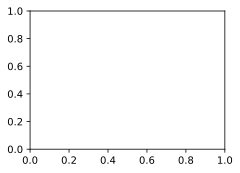

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

欠拟合，

AttributeError: module 'd2l.torch' has no attribute 'train_epoch_ch3'

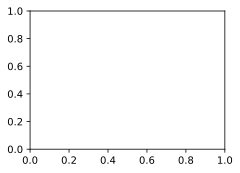

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

过拟合

In [ ]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)